In [1]:
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

/var/folders/qy/wgv4ntq52lgbk979f6lm7pbh0000gn/T/ipykernel_73151/3568515526.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial3"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [3]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [4]:
class ActivationFunction(nn.Module):

    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [5]:
##############################

class Sigmoid(ActivationFunction):

    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################

class Tanh(ActivationFunction):

    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

In [6]:
##############################

class ReLU(ActivationFunction):

    def forward(self, x):
        return x * (x > 0).float()

##############################

class LeakyReLU(ActivationFunction):

    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################

class ELU(ActivationFunction):

    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

##############################

class Swish(ActivationFunction):

    def forward(self, x):
        return x * torch.sigmoid(x)

##############################

In [7]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

In [8]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor.
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"


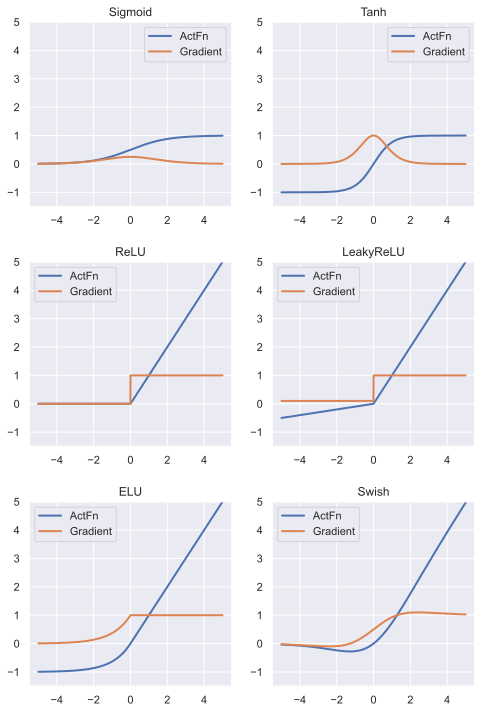

In [9]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

In [10]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence

        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out

In [11]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net

def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.

    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [12]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:07<00:00, 3522090.37it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 203351.47it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:01<00:00, 3019301.26it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5031991.84it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



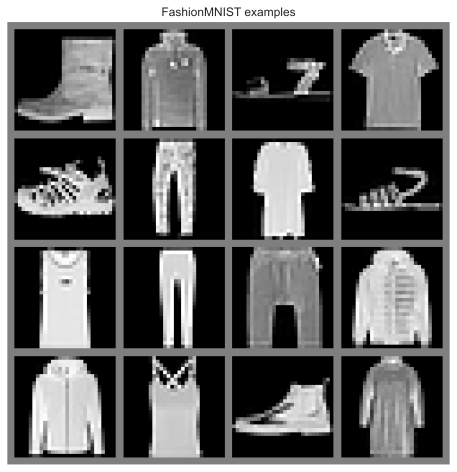

In [13]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [14]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    net.zero_grad()
    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

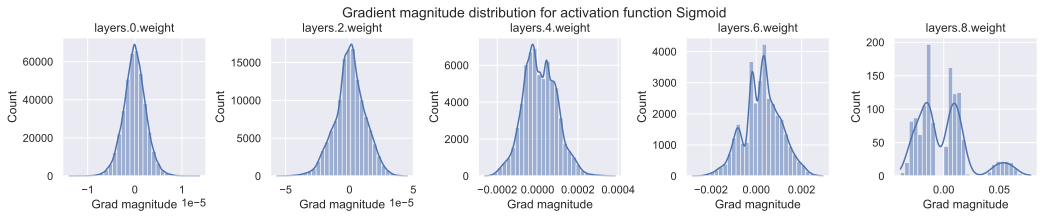

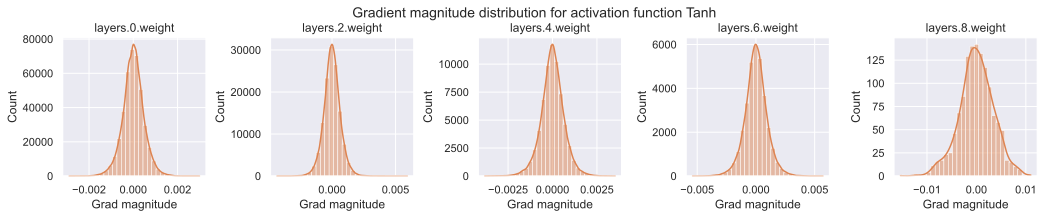

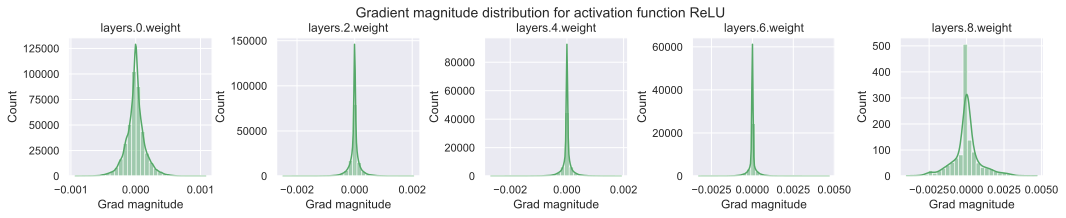

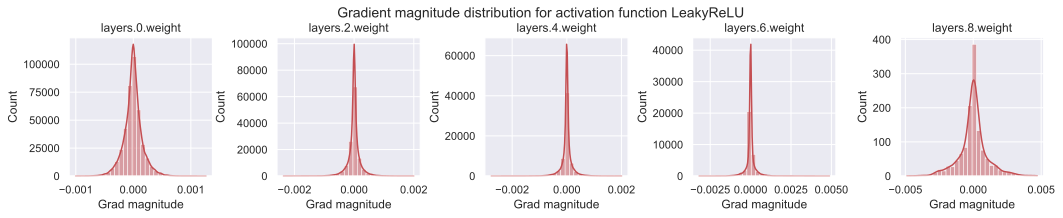

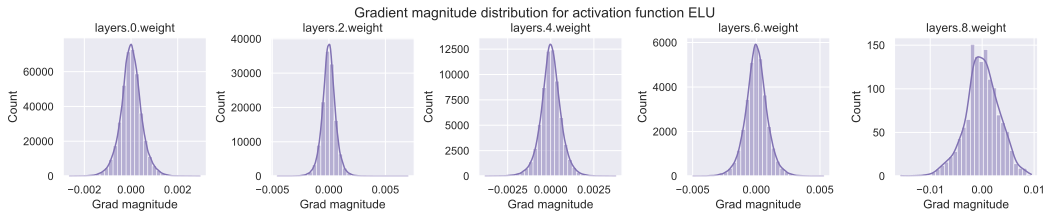

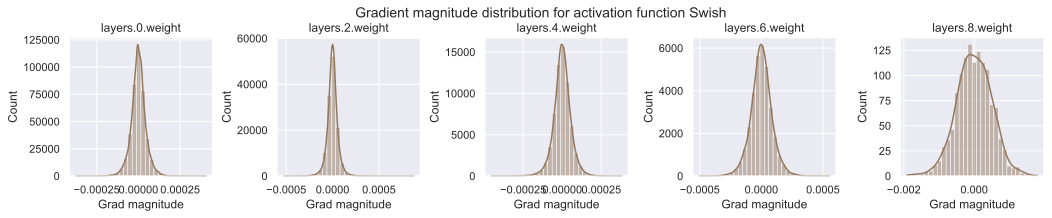

In [15]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")